In [2]:
import sys
import os
sys.path.append("..")
from commembed.jupyter import *
import commembed.linalg as linalg
import commembed.dimens as dimens
import numpy as np
import pandas as pd
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import datetime
from tqdm.notebook import tqdm
tqdm.pandas()
import seaborn as sns
import matplotlib.gridspec as gridspec
#import commembed.data as data
#spark = data.spark_context()

matplotlib.rcParams['mathtext.fontset'] = 'custom'

%config InlineBackend.figure_format = 'retina'
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
embedding = load_embedding('reddit', 'master')
dimen_list = dimens.load_dimen_list('final')
scores = dimens.score_embedding(embedding, dimen_list)
plt.rcParams['font.family'] = 'Arial'

In [4]:
# Print dimension correlations
import scipy.stats
dimens_to_print = ['age','gender','partisan','age_b','gender_b','partisan_b']
pd.DataFrame([
    (d1, d2, "r=%.2f;p=%e" % scipy.stats.pearsonr(scores[d1],scores[d2])) for d1 in dimens_to_print for d2 in dimens_to_print
], columns=['d1','d2','val']).pivot(index='d1',columns='d2')

val                           \
d2                             age                    age_b   
d1                                                            
age          r=1.00;p=0.000000e+00    r=0.90;p=0.000000e+00   
age_b        r=0.90;p=0.000000e+00    r=1.00;p=0.000000e+00   
gender       r=0.10;p=4.133673e-25    r=0.04;p=1.693353e-05   
gender_b    r=-0.17;p=1.753619e-64  r=-0.26;p=5.968727e-158   
partisan    r=-0.37;p=0.000000e+00  r=-0.33;p=1.476016e-255   
partisan_b  r=-0.13;p=2.466485e-37    r=0.05;p=1.724888e-07   

                                                              \
d2                           gender                 gender_b   
d1                                                             
age           r=0.10;p=4.133673e-25   r=-0.17;p=1.753619e-64   
age_b         r=0.04;p=1.693353e-05  r=-0.26;p=5.968727e-158   
gender        r=1.00;p=0.000000e+00    r=0.86;p=0.000000e+00   
gender_b      r=0.86;p=0.000000e+00    r=1.00;p=0.000000e+00   
partisan    r=-0.29;p=2.113918e-199  r=-0.26;p=8.720269e-150   
partisan_b  r=-0.34;p=2.687404e-270   r=-0.38;p=0.000000e+00   

                                                              
d2                         partisan               partisan_b  
d1                                                            
age          r=-0.37;p=0.000000e+00   r=-0.13;p=2.466485e-37  
age_b       r=-0.33;p=1.476016e-255    r=0.05;p=1.724888e-07  
gender      r=-0.29;p=2.113918e-199  r=-0.34;p=2.687404e-270  
gender_b    r=-0.26;p=8.720269e-150   r=-0.38;p=0.000000e+00  
partisan      r=1.00;p=0.000000e+00    r=0.55;p=0.000000e+00  
partisan_b    r=0.55;p=0.000000e+00    r=1.00;p=0.000000e+00

In [5]:
# Remove porn
remove_porn = False
if remove_porn:
    clustering = load_clustering('reddit')
    clustering = clustering[clustering["cluster_name"] == "Porn (heterosexual)"]
    print(len(scores))
    scores = scores[~scores.index.isin(clustering.index)]
    print(len(scores))

In [6]:
def add_subplot_label(ax, label, x=-240, y=0): 
    ax.annotate(label, xy=(0, 1), xycoords='axes fraction',
      xytext=(x, y), textcoords='offset points',
      fontsize=16, fontweight='bold', va='top', ha='left')

partisan, age: r = -0.37; p = 0.000000e+00
Total Highly Democrat = (291)
Total Highly Republican = (176)


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


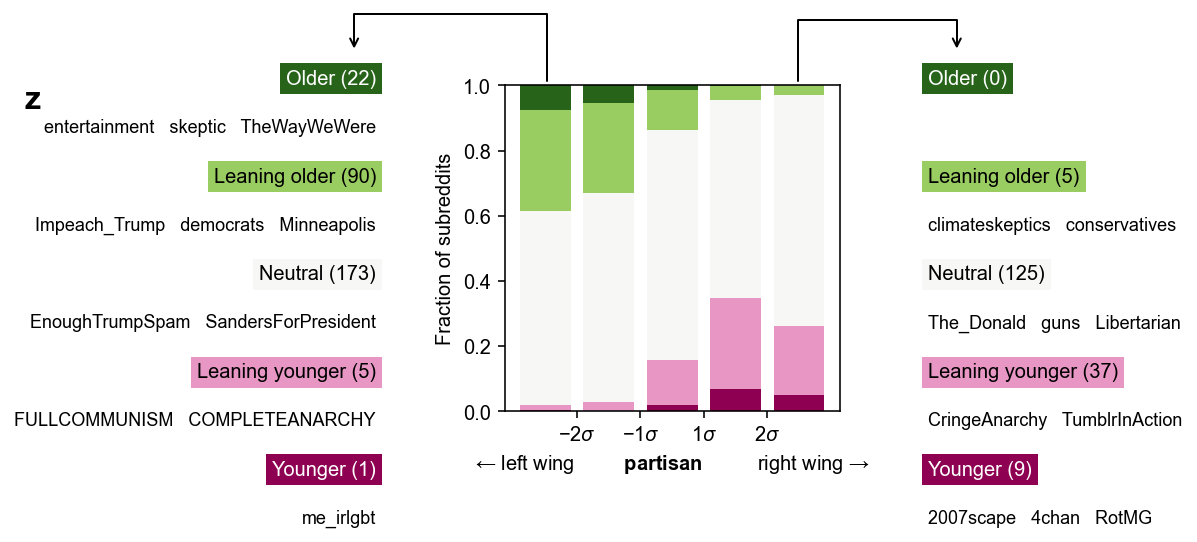

In [7]:
import textwrap
from matplotlib.patches import Rectangle
import scipy.stats

def community_side_box(ax, color, x, y, title, communities, px, py, arrow=False, light_text=False, glossary=None, alignment='left'):
    props = dict(boxstyle='square', facecolor='wheat', linewidth=0)
    props["facecolor"] = color
    textcolor = "black"
    if light_text:
        textcolor = "white"
    
    text = "   ".join(communities)
    text = textwrap.fill(text, 40).split("\n")
    text = "\n".join(text[0:min(1, len(text))])

    arrowprops = dict(arrowstyle='->', color=props["facecolor"],
                        patchA=None, patchB=None, connectionstyle='arc, angleA=90, angleB=90')
    if not arrow:
        arrowprops = None
        
    if glossary is not None:
        glossary.extend(text.split("   "))
    
    fontsize = 9
    
    x += 0.15 * np.sign(x)
    
    ha = alignment
    
    ax.annotate(title + " (%d)" % (len(communities)), color=textcolor,
                xy=(px, py), xycoords='data',
                xytext=(x*1.1, y), textcoords='axes fraction', fontsize=10,
        verticalalignment='top', bbox=props, ha=ha,
               arrowprops=arrowprops)

    ax.text(x*1.1, y - 0.15, text, transform=ax.transAxes, fontsize=fontsize, ha=ha,
        verticalalignment='top')
    

def render_bar_plot(fig, gs, x, y, label=None, glossary=[], show_communities=True):
    ax = fig.add_subplot(gs)
    
    quantile_names = {
        "partisan": ["Highly Democrat", "Leaning Democrat", "Neutral", "Leaning Republican", "Highly Republican"],
        "gender": ["Masculine", "Leaning masculine", "Neutral", "Leaning feminine", "Feminine"],
        "affluence": ["Highly poor", "Leaning poor", "Neutral", "Leaning affluent", "Highly affluent"],
        "age": ["Younger", "Leaning younger", "Neutral", "Leaning older", "Older"],
    }
    quantile_default = ["Highly", "Leaning", "Neutral", "Leaning", "Highly"]
    n_quantiles = 5
    use_quantiles = False
    use_z_scores = True
    
    x_normed = x.split("_")[0]
    y_normed = y.split("_")[0]
    
    r, p = scipy.stats.pearsonr(scores[x], scores[y])
    print("%s, %s: r = %.2f; p = %e" % (x, y, r, p))

    to_plot = scores.copy()
    #to_plot = to_plot[to_plot["partisan_neutral"] >= 0.5178751874396346]
    if use_z_scores:
        x_std = np.std(to_plot[x])
        y_std = np.std(to_plot[y])
        x_mean = np.mean(to_plot[x])
        y_mean = np.mean(to_plot[y])
        x_bins = np.array([-x_std*2, -x_std, x_std, x_std*2]) + x_mean
        y_bins = np.array([-y_std*2, -y_std, y_std, y_std*2]) + y_mean
    elif use_quantiles:
        x_bins = np.percentile(to_plot[x], np.linspace(0, 100, n_quantiles+1)[1:-1])
        y_bins = np.percentile(to_plot[y], np.linspace(0, 100, n_quantiles+1)[1:-1])
    else:
        pctls = [0, 100]#[0.1, 99.9]
        x_threshs = np.percentile(scores[x], pctls)
        y_threshs = np.percentile(scores[y], pctls)
        x_bins = np.linspace(x_threshs[0], x_threshs[1], n_quantiles+1)[1:-1]
        y_bins = np.linspace(y_threshs[0], y_threshs[1], n_quantiles+1)[1:-1]
    to_plot[x] = np.digitize(to_plot[x], x_bins)
    to_plot[y] = np.digitize(to_plot[y], y_bins)


    to_plot = to_plot.join(embedding.metadata)
    to_plot["total_users"] = to_plot["total_users"].astype(float)

    to_plot_by_community = to_plot

    to_plot["n"] = 1
    to_plot = to_plot.groupby([x,y]).agg("count").reset_index()
    total_counts = to_plot.groupby(x).agg("sum")
    to_plot = to_plot.set_index(x)
    to_plot["frac"] = to_plot["n"] / total_counts["n"]


    import matplotlib
    import matplotlib.colors as colors
    import textwrap

    cmap_norm = colors.Normalize(vmin=0, vmax=n_quantiles-1)
    cmap = axis_colormap(y)
    m = matplotlib.cm.ScalarMappable(norm=cmap_norm, cmap=cmap)

    xinds = np.arange(0, n_quantiles)
    bottoms = np.zeros((n_quantiles, n_quantiles))
    for category, rows in to_plot.reset_index().sort_values(y).groupby(y):
        rows = rows.set_index(x).reindex(xinds)
        ax.bar(rows.index, rows["frac"],bottom=bottoms[category, :], label=quantile_names.get(y_normed, quantile_default)[category], color=m.to_rgba(category))
        if category < n_quantiles-1:
            bottoms[category+1, :] = bottoms[category, :] + rows["frac"].fillna(0)

            

    ax.set_xticks((xinds+0.5)[:-1])
    ax.set_xticklabels(["$ %d \sigma$" % stddev for stddev in [-2, -1, 1, 2]])
    ax.set_xlabel(axis_label(x))
    #plt.setp(ax.get_xticklabels(), rotation=-45, horizontalalignment="left")
    #plt.legend()
    ax.set_ylabel("Fraction of subreddits")
    #plt.title(x)
        
    if not show_communities:
            
        if label is not None:
            add_subplot_label(ax, label, x=-50)
        return
    
    
            
    if label is not None:
        add_subplot_label(ax, label)
            
    for x_category, offset in [(0,-0.2), (4,1)]:
        groups = to_plot_by_community[to_plot_by_community[x] == x_category].reset_index().sort_values(y).groupby(y)
        groups_by_key = {y_category: rows for y_category, rows in groups}
        total_in_x = sum([len(g) for _, g in groups])
        groups = [0, 1, 2, 3, 4]
        box_y = (5 - len(groups)) / 2
        
        group_lens = [len(groups_by_key.get(ycat, [])) for ycat in groups]
        print("Total %s = (%d)"% (quantile_names.get(x_normed, quantile_default)[x_category], total_in_x))
        
        for y_category in groups:
            rows = groups_by_key.get(y_category, None)

                
            title = quantile_names.get(y_normed, quantile_default)[y_category]

            ypos = 0.6 + (box_y / 5 - 0.5) * 1.5
            
            if rows is None:
                communities = []
            else:
                rows = rows.sort_values("total_users", ascending=False)
                rows = rows
                communities = rows["community"].values

            bottom = bottoms[y_category, x_category]
            bottom += (bottoms[y_category+1, x_category]-bottom)/2 if y_category < n_quantiles-1 else (1-bottom)/2

            color = m.to_rgba(y_category)
            px, py = (x_category, bottom)

            community_side_box(ax, color, offset, ypos, title, communities, px, py, light_text=(y_category == 0 or y_category == 4),
                              glossary=glossary, alignment='left' if offset==1 else 'right')


            box_y = box_y + 1
    
    
    
    ax.annotate("", xy=(-0.45, 1.1), xytext=(0.125, 1), xycoords='axes fraction',
             arrowprops=dict(arrowstyle="->", connectionstyle ="bar,angle=180,fraction=0.2"))
    ax.annotate("", xy=(1-0.125, 1), xytext=(1.35, 1.1), xycoords='axes fraction',
             arrowprops=dict(arrowstyle="<-", connectionstyle ="bar,angle=180,fraction=0.2"))
    
    #ax.add_patch(Rectangle((-6.6, -0.4), 5, 1.25,alpha=1, clip_on=False))
    #ax.add_patch(Rectangle((4.8, -0.5), 5, 1.25,alpha=1, clip_on=False))
    
    
x = "partisan"
y = "age"

fig = plt.figure(figsize=(3,3))
render_bar_plot(fig, gridspec.GridSpec(1, 1, figure=fig)[0,0], x, y, label="z")
plt.show()

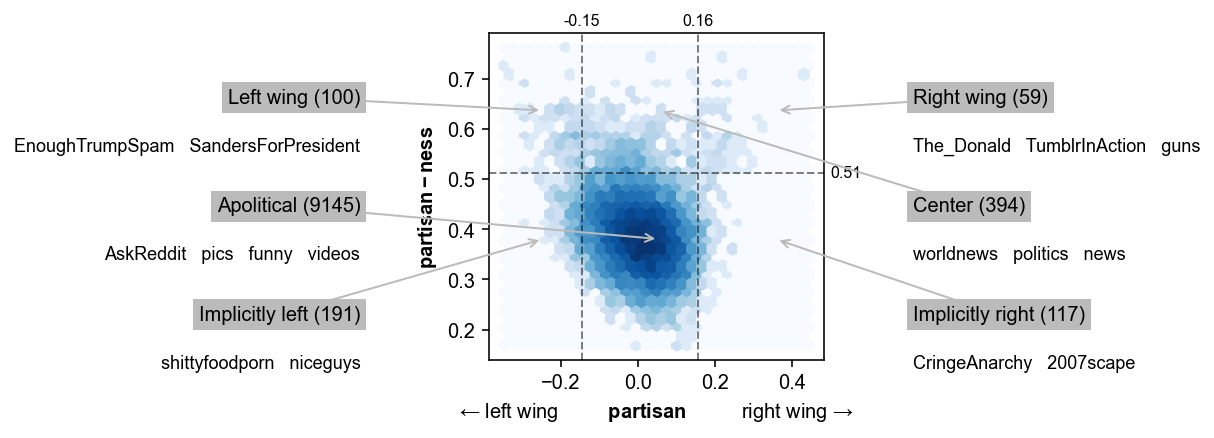

In [8]:
from matplotlib.patches import Rectangle


def render_hex_plot(fig, gs, x, y, label=None,glossary=[]):
    ax = fig.add_subplot(gs)
    
    
    ax.set_xlabel(axis_label(x))
    ax.set_ylabel(axis_label(y))
    
    ax.hexbin(scores[x], scores[y], cmap='Blues', gridsize=30, bins='log', rasterized=True)

    
    neutral_cutoff = neutral_cutoffs["partisan"]
    
    mean_partisan = np.mean(scores[x])
    std_partisan = np.std(scores[x])
    right = mean_partisan+std_partisan*2
    left = mean_partisan-std_partisan*2
    
    ax.annotate("%.2f" % left, (left, 0.8), ha='center', va='bottom', annotation_clip=False, fontsize=8)
    ax.annotate("%.2f" % right, (right, 0.8), ha='center', va='bottom', annotation_clip=False, fontsize=8)
    ax.annotate("%.2f" % neutral_cutoff, (0.5, neutral_cutoff), ha='left', va='center', annotation_clip=False, fontsize=8)
    
    alpha = 0.05
    
    ax.axhline(neutral_cutoff, c='black', linewidth=1, linestyle='--', alpha=0.5)
    ax.axvline(left, c='black', linewidth=1, linestyle='--', alpha=0.5)
    ax.axvline(right, c='black', linewidth=1, linestyle='--', alpha=0.5)
    
    #ax.add_patch(Rectangle((left, neutral_cutoff), -10, 10, facecolor=dem, alpha=alpha))
    #ax.add_patch(Rectangle((right, neutral_cutoff), -std_partisan*4, 10, facecolor=neutral, alpha=alpha))
    #ax.add_patch(Rectangle((right, neutral_cutoff), 10, 10, facecolor=rep, alpha=alpha))
    
    
    #ax.add_patch(Rectangle((left, neutral_cutoff), -10, -10, facecolor=ldem, alpha=alpha))
    #ax.add_patch(Rectangle((right, neutral_cutoff), 10, -10, facecolor=lrep, alpha=alpha))
    
    to_plot = scores.copy()
    
    to_plot = to_plot.join(embedding.metadata)
    to_plot["total_users"] = to_plot["total_users"].astype(float)
    to_plot = to_plot[[x,y,"total_users"]]
    to_plot[x] = np.digitize(to_plot[x], [left, right])
    to_plot[y] = np.digitize(to_plot[y], [neutral_cutoff])
    
    categories = [(a, b) for b in range(0,3) for a in range(0, 2) ]
    titles = {(1,0):"Left wing",(1,1):"Center",(1,2):"Right wing",
              (0,0):"Implicitly left",(0,1):"Apolitical",(0,2):"Implicitly right"}
    
    c1 = np.array([left - (left - np.amin(scores[x]))/2, neutral_cutoff + (np.amax(scores[y])-neutral_cutoff)/2])
    
    
    coords = {(1,0):c1, (1,1):c1+[right-left, 0],(1,2):c1+[(right-left)*2, 0],
              (0,0):c1+[0, -neutral_cutoff/2],(0,1):c1+[right-left, -neutral_cutoff/2],(0,2):c1+[(right-left)*2, -neutral_cutoff/2]}
    
    categories = [(0,0),(0,1),(1,0),(0,2),(1,1),(1,2)]
    for i,cat in enumerate(categories):
        is_political, affiliation = cat
        rows = to_plot[to_plot[x] == affiliation]
        rows = rows[rows[y] == is_political].sort_values("total_users", ascending=False)
        
        community_side_box(ax, "#bbbbbb", 1 if int(i/3)>0 else -0.2, (0.5+(i%3))/3, titles.get(cat, None), rows.index.values,
                           coords[cat][0], coords[cat][1], arrow=True, glossary=glossary,
                          alignment= 'left' if int(i/3)>0 else 'right')
        
        
    
    if label is not None:
        add_subplot_label(ax, label)
    
    
x = "partisan"
y = "partisan_neutral"

fig = plt.figure(figsize=(3,3))
render_hex_plot(fig, gridspec.GridSpec(1, 1, figure=fig)[0,0], x, y)
plt.show()

partisan, gender: r = -0.29; p = 2.113918e-199
Total Highly Democrat = (291)
Total Highly Republican = (176)
partisan, age: r = -0.37; p = 0.000000e+00
Total Highly Democrat = (291)
Total Highly Republican = (176)


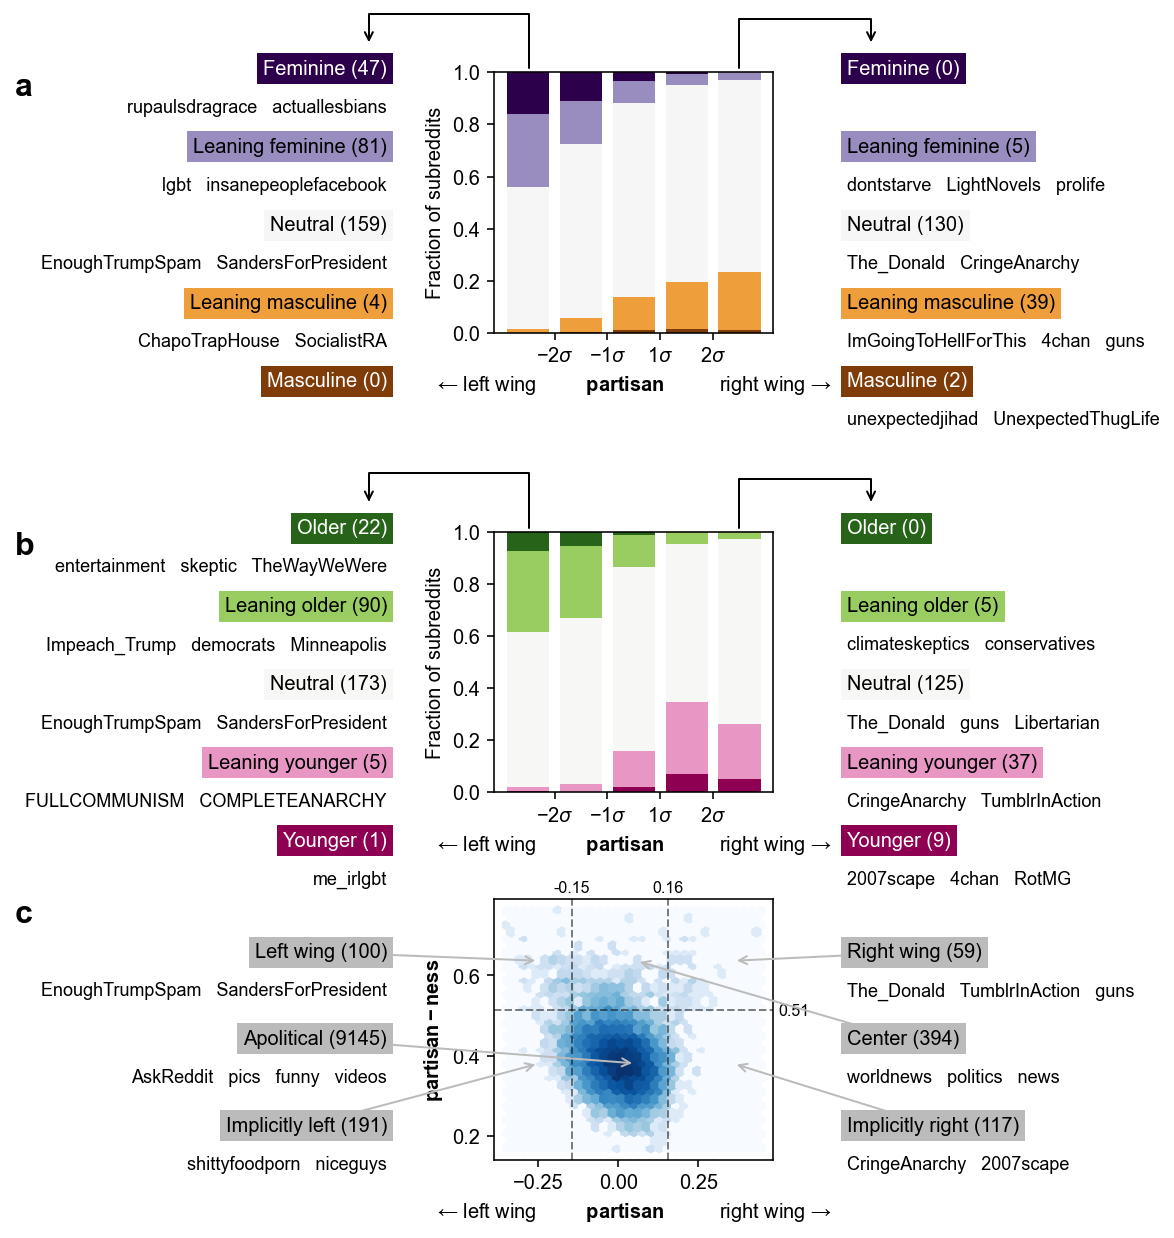

In [9]:
def render_joint_plot(use_bs=False):
    
    glossary = []

    size = 10
    fig = plt.figure(figsize=(size/4,size))

    gs0 = gridspec.GridSpec(12, 1, figure=fig)

    gs1 = gs0[0:3, 0]
    gs2 = gs0[5:8, 0]
    gs3 = gs0[9:12, 0]
    
    partisan = "partisan" if use_bs else "partisan"
    gender = "gender_b" if use_bs else "gender"
    age = "age_b" if use_bs else "age"

    render_bar_plot(fig, gs1, partisan, gender, label="a", glossary=glossary)
    render_bar_plot(fig, gs2, partisan, age, label="b", glossary=glossary)
    render_hex_plot(fig, gs3, partisan, partisan+"_neutral", label="c", glossary=glossary)
    
    return fig, glossary
    
render_joint_plot(use_bs=False)
plt.show()

partisan, gender: r = -0.29; p = 2.113918e-199
partisan, age: r = -0.37; p = 0.000000e+00


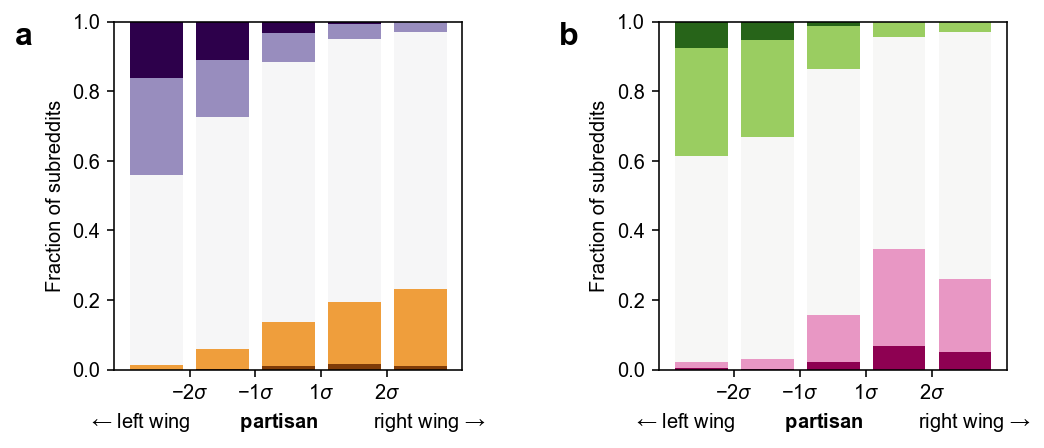

In [10]:
def render_compact_joint_plot(use_bs=False):
    
    glossary = []

    scalefac = 0.8
    fig = plt.figure(figsize=(10*scalefac,4*scalefac))

    gs0 = gridspec.GridSpec(1, 10, figure=fig)

    gs1 = gs0[0, 0:4]
    gs2 = gs0[0, -4:]
    
    partisan = "partisan" if use_bs else "partisan"
    gender = "gender_b" if use_bs else "gender"
    age = "age_b" if use_bs else "age"

    render_bar_plot(fig, gs1, partisan, gender, label="a", glossary=glossary, show_communities=False)
    render_bar_plot(fig, gs2, partisan, age, label="b", glossary=glossary, show_communities=False)
    
    return fig, glossary
    
render_compact_joint_plot(use_bs=False)
plt.show()

In [ ]:
save_paper_figure(render_compact_joint_plot(use_bs=False), "fig_3_joint")
save_paper_figure(render_joint_plot(use_bs=False), "fig_A_joint_bars", filetype='tiff')
save_paper_figure(render_joint_plot(use_bs=True), "fig_A_joint_bars_w_bs")